# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

In [3]:
path = Path('/local/burghbvander/110kDBRDv2_no_pretrain/')
path.ls()

[PosixPath('/local/burghbvander/110kDBRDv2_no_pretrain/tmp_lm'),
 PosixPath('/local/burghbvander/110kDBRDv2_no_pretrain/test'),
 PosixPath('/local/burghbvander/110kDBRDv2_no_pretrain/unsup'),
 PosixPath('/local/burghbvander/110kDBRDv2_no_pretrain/urls.txt'),
 PosixPath('/local/burghbvander/110kDBRDv2_no_pretrain/tmp_clas'),
 PosixPath('/local/burghbvander/110kDBRDv2_no_pretrain/train'),
 PosixPath('/local/burghbvander/110kDBRDv2_no_pretrain/models')]

In [4]:
bs=118

In [5]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

In [8]:
data_lm = load_data(path, 'tmp_lm', bs=bs)

In [6]:
data_lm.show_batch()

idx,text
0,"ik uiteindelijk wel zeker , xxmaj matthias was dood . \n xxmaj uit de verschillende verhaallijnen heb ik echter nooit kunnen distilleren wie xxmaj matthias nu wel was . xxmaj wel was het duidelijk dat hij op zijn weg heel wat tegenslagen te verwerken kreeg en niet altijd begrepen werd . \n xxmaj ik kreeg wel een beter beeld van de naasten van xxmaj matthias . \n"
1,"de schrijver . \n ' xxmaj het is autobiografisch , helemaal waargebeurd maar toch zie je elementen van fictie in de stijl en vooral de opbouw , dat maakt het des te sterker . ' - xxmaj win boeken voor je hele leesclub ! \n ' xxmaj wat beweegt de jonge zwarte deelpachter xxmaj tucker xxmaj caliban om huis , vee en akkers te vernietigen en met vrouw"
2,"xxmaj win boeken voor je hele leesclub ! \n ' xxmaj wat beweegt de jonge zwarte deelpachter xxmaj tucker xxmaj caliban om huis , vee en akkers te vernietigen en met vrouw en kind naar het xxmaj noorden te vertrekken?'- xxmaj win xxmaj uit de maat voor je hele leesgroep ! \n xxmaj we gaan xxmaj wil van xxmaj jeroen xxmaj olyslaegers luisteren via de gratis xxmaj hebban"
3,"xxmaj je leert veel over het katholieke geloof , de verschillende stromingen , geschiedenis en gebruiken . xxmaj al vanaf de eerste bladzijden toont xxmaj caldwell zich een goed onderwijzer , de inleiding is een historische kanttekening over de verschillende stromingen binnen deze religie . xxmaj in het verhaal wordt uitvoerig ingegaan op het verloop van het xxunk onderzoek binnen het xxmaj vaticaan . xxmaj de zorgvuldig uitgewerkte details hebben"
4,"mag xxmaj ambrose van zijn moeder niet met hem omgaan . xxmaj totdat hij erachter komt dat ze allebei gek zijn op xxunk ... \n \n xxmaj het eerste wat mij opviel was dat xxunk een grote rol speelt in het boek . xxmaj ambrose is natuurlijk gek op xxunk , dus komt dat ook veel voor in het boek . xxmaj zo is de de titel van het"


## Language model

In [7]:
from fastai.text.models import AWD_LSTM

In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02


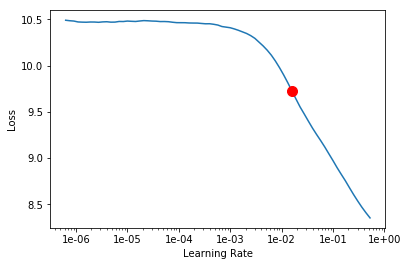

In [10]:
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.861142,3.681137,0.362308


In [12]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [13]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-05


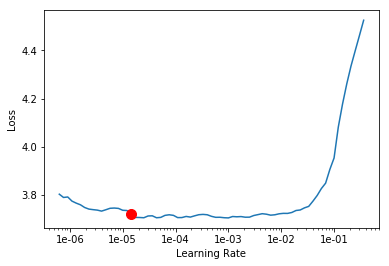

In [15]:
learn.recorder.plot(skip_end=15)

In [16]:
from fastai.callbacks import SaveModelCallback
cb = SaveModelCallback(learn, every='epoch')

In [17]:
learn.fit_one_cycle(20, 1e-4, moms=(0.8,0.7), callbacks=[cb])

epoch,train_loss,valid_loss,accuracy
1,3.671035,3.603990,0.369439
2,3.600048,3.526203,0.377952
3,3.522176,3.446175,0.386902
4,3.407556,3.374015,0.395235
5,3.359415,3.314743,0.402030
6,3.335450,3.266584,0.407596
7,3.274744,3.229975,0.411999
8,3.243505,3.200530,0.415410
9,3.209189,3.177683,0.418160
10,3.209921,3.158360,0.420391


KeyboardInterrupt: 

In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [18]:
learn.load('bestmodel_13');

In [ ]:
TEXT = "Wat een fantastisch boek"
N_WORDS = 40
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [19]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [5]:
bs = 32

In [42]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [6]:
data_clas = load_data(path, 'tmp_clas', bs=bs)

In [21]:
data_clas.show_batch()

text,target
"xxbos “ xxmaj het huwelijk is het graf van de liefde . ” \n \n xxmaj woorden , woorden , woorden . xxmaj in de juiste volgorde vormen ze een universum waarin je helemaal wil verdwijnen . xxmaj alleen al bij het horen van de naam xxmaj proust word ik – heel toepasselijk - teruggeworpen naar die heerlijke weken waarin ik mocht verdwalen in de omgeving van xxmaj xxunk",neg
"xxbos xxup de xxup cover \n \n xxmaj de cover toont een xxunk zoals xxmaj homeros dat waarschijnlijk in zijn gedachten had toen hij de ' xxmaj odysseus ' geschreven heeft . \n \n xxmaj op de achtergrond zie je felle xxunk die van een onweer kunnen zijn , maar evengoed kan het de verschijning van één of andere god zijn . xxmaj het gaat nu éénmaal over",pos
"xxbos xxmaj het is zo treurig dat in het tijdperk waarin iedereen ( in de vrije wereld althans ) uitstekend xxunk is om de juistheid of xxunk van elke stelling , elke bewering zelf na te gaan , vrijwel niemand de moeite neemt om het te doen . xxmaj het kritisch vermogen ontbreekt kennelijk volkomen . xxmaj een paar xxunk en je duikt in gedigitaliseerde archieven , bekijkt ebook versies",neg
"xxbos xxmaj david xxmaj garnett ( 1892 - 1981 ) schreef dit debuut al in 1922 en de novelle werd meteen als meesterwerk bestempeld . xxmaj hij maakte destijds deel uit van de xxmaj xxunk - die bestond uit schrijvers , kunstenaars en intellectuelen - waar onder andere ook xxmaj virginia xxmaj woolf , haar echtgenoot xxmaj leonard xxmaj woolf , xxmaj vanessa en xxmaj clive xxmaj bell , xxmaj",pos
"xxbos xxmaj hij is wonderbaarlijk lichtvoetig , die xxmaj daniel xxmaj kehlmann , en gezegend met een onbegrijpelijk soepele pen . xxmaj ogenschijnlijk achteloos schudt hij de ene originele en vederlichte zin na de andere uit de mouw , en hij presenteert allerlei filosofische thema 's of tragische scenes met zo'n virtuositeit en souplesse dat je de zwaarte en complexiteit van hun inhoud bijna vergeet . xxmaj sommige recensenten vinden",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [7]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-01


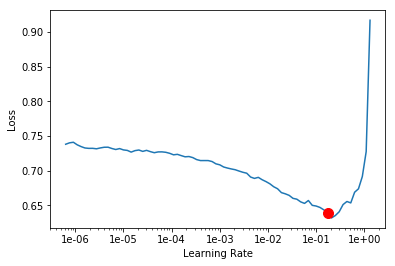

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.524042,0.408599,0.811843


In [30]:
learn.save('first')

In [37]:
learn.load('first');

In [38]:
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.414296,0.267585,0.892073
2,0.324129,0.229228,0.914040
3,0.299521,0.225934,0.914518
4,0.275685,0.208143,0.927412
5,0.252172,0.216482,0.923114


In [39]:
learn.save('second')

In [8]:
learn.load('second');

In [33]:
from fastai.callbacks import SaveModelCallback
cb = SaveModelCallback(learn)

In [34]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-6/(2.6**4),5e-5), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.326048,0.236189,0.903534


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.242930,0.217729,0.923114


In [ ]:
learn.save('fitted')  # better train loss, same accuracy

In [ ]:
learn.show_results(rows=10)

In [ ]:
interp = learn.interpret()

In [ ]:
interp.plot_confusion_matrix()